In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
#1a
def quadraticpotential_grad(q1):
    """Given an input q1, returns the gradient of U with respect to q, for U(q) = 1/2 q^T*q"""
    return q1

def leapfrog(q0, p0, tau, L, M, U_gradient):
    """Computes and returns the discrete solution (qn, pn) to (5) (the Hamiltonian dynamics)
    at all times tn = n*tau for 0 ≤ n ≤ L, using the leapfrog integrator. 

    inputs:     initial states q0, p0, 
                a time step tau
                L = the number of steps
                M = a positive definite matrix
                U_gradient = the gradient of the potential energy"""

    #Calculate inverse of M
    if np.size(M) != 1:
        Minv = np.linalg.inv(M)
    else:
        Minv = M

    #determine dimension of random variables
    if np.size(q0) != 1:
        d = len(q0)
    else:
        d = 1
        
    p = np.zeros((L+1, d))
    q = np.zeros((L+1, d))
    p[0] = p0
    q[0] = q0

    for n in range(L):
        #Leapfrog integrator:
        p_half = p[n] - tau/2 * U_gradient(q[n])
        q[n+1] = q[n] + tau * np.dot(Minv , p_half) 
        p[n+1] = p_half - tau/2 *  U_gradient(q[n+1])
        
    return q, p


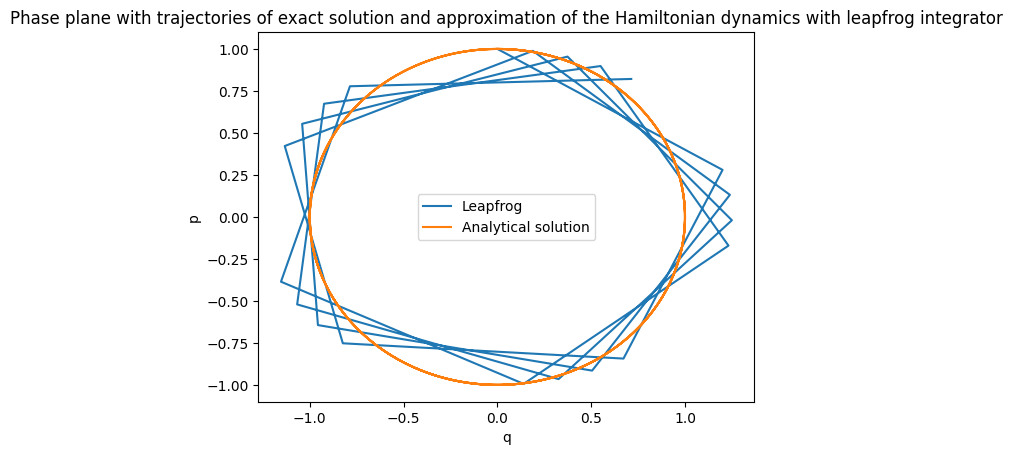

In [3]:
#1b plot 1

#set values
d = 1
M = 1 
def U(q):
    return 1/2 * q**2
def H(q, p):
    return 1/2 * q**2 + 1/2 * p**2
q0 = 0 
p0 = 1 
tau = 1.2
L = 20

#leapfrog integrator
q_vector, p_vector = leapfrog(q0, p0, tau, L, M, quadraticpotential_grad)

#calculate analytical solutions
t_vector = np.linspace(0, 24, num=500)

def q(t):
    return -np.cos(t + np.pi/2)

def p(t):
    return np.sin(t + np.pi/2)

q_anal = q(t_vector)
p_anal = p(t_vector)

#plot the Leapfrog solutions with the analytical 

plt.plot(q_vector, p_vector, label = 'Leapfrog')
plt.plot(q_anal, p_anal, label = 'Analytical solution')
plt.xlabel('q')
plt.ylabel('p')
plt.title('Phase plane with trajectories of exact solution and approximation of the Hamiltonian dynamics with leapfrog integrator')
plt.legend()
#to save the figure
plt.savefig("figure.png",bbox_inches = 'tight')
plt.show()

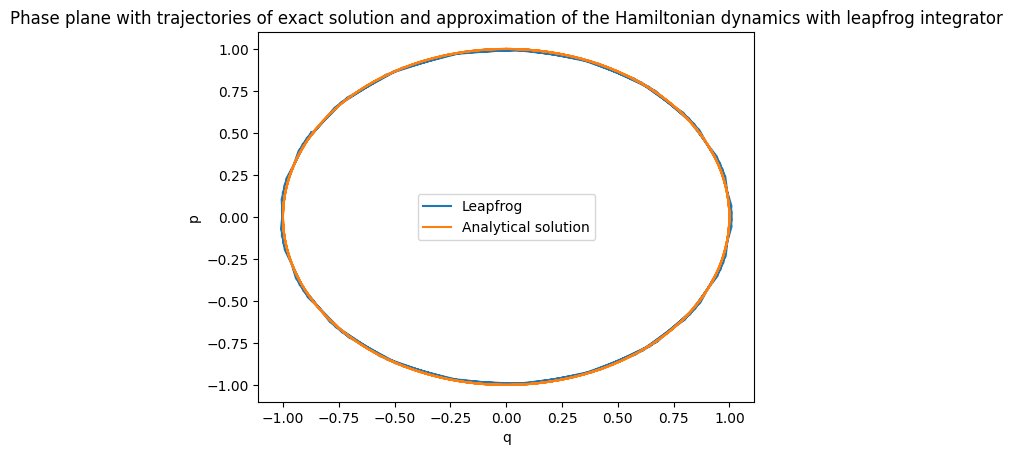

In [4]:
#1b plot 2

tau = 0.3 
L = 80 

#Calculate with leapfrog integrator
q_vector1, p_vector1 = leapfrog(q0, p0, tau, L, M, quadraticpotential_grad)

#plot the Leapfrog solutions with the analytical 
plt.plot(q_vector1, p_vector1, label = 'Leapfrog')
plt.plot(q_anal, p_anal, label = 'Analytical solution')
plt.xlabel('q')
plt.ylabel('p')
plt.title('Phase plane with trajectories of exact solution and approximation of the Hamiltonian dynamics with leapfrog integrator')
plt.legend()
#to save the figure
plt.savefig("figure2.png",bbox_inches = 'tight')
plt.show()

In [5]:
#(f) +(h)
sigma_vector = np.linspace(0.01, 1, 100)

def potential(q1):
    return 1/2 * np.sum((q1/sigma_vector)**2)

def potential_grad(q1):
    return q1/(sigma_vector**2)

#(f)

def HMC_sampling(N, q0, L, tau, potential, potential_grad):
    """Routine that samples using Hamiltonian Monte Carlo sampling
    
    Input: 
        N = desired samples, q0 = initial position, L = number of steps, tau = step size
        
        Output:
        N samples from the target distribution, i.e. samples of q"""
    
    #determine the dimension
    if np.size(q0) != 1: 
        d = len(q0)
    else:
        d = 1

    #make output vectors and initialize q0
    q_vector = np.zeros((N,d))
    p_vector = np.zeros((N, d))
    q_vector[0] = q0
    
    #Matrix for the kinetic energy K(p)
    M = np.identity(d) 
    
    #HMC steps:
    for t in range(1, N):
        #uncomment line below for (h)
        tau = np.random.uniform(0.0104, 0.0156)
        p_vector[t-1] = np.random.multivariate_normal(np.zeros(100), M)
        q_star, p_star = leapfrog(q_vector[t-1], p_vector[t-1], tau, L, M, potential_grad)
        
        #compute Hamiltonians H_star = H(q_star, p_star) and H_previous = H(q_vector[t-1], p_vector[t-1]))
        #we use that H(q, p) = U(q) + K(p):
        H_star = potential(q_star[-1]) + 1/2 * np.dot(p_star[-1], p_star[-1])
        H_previous = potential(q_vector[t-1]) + 1/2 * np.dot(p_vector[t-1], p_vector[t-1])

        #Metropolization step
        alpha = min(1, np.exp(-H_star+ H_previous))

        #accept/reject: 
        u = np.random.uniform(0,1)
        if alpha >= u: #accept
            q_vector[t], p_vector[t] = q_star[-1], p_star[-1]
        else: #reject
            q_vector[t], p_vector[t] = q_vector[t-1], p_vector[t-1]
    return q_vector


In [6]:
#(g)

# f = target distribution
# g = symmetric distribution 

def Random_walk_MH(q0, N):
    """Sample from a target distribution with Random walk Metropolis-Hastings algorithm.
    Input: 
        q0 = starting value, N = number of required samples
    Output: 
         N samples"""

    #determine the dimension
    if np.size(q0) != 1:
        d = len(q0)
    else: 
        d=1

    #make vector and fill in starting value
    X_vector = np.zeros((N, d))
    X_vector[0] = q0
    
    #the random walk MH algorithm:
    for t in range(N):
        #draw from the symmetric distribution g()
        epsilon = g()

        #random walk step
        X = X_vector[t-1] + epsilon

        #Metropolization step
        alpha = min(1, f(X)/f(X_vector[t-1]))

        #accept/reject
        u = np.random.uniform(0,1)
        if u <= alpha: #accept
            X_vector[t] = X
        else: #reject
            X_vector[t] = X_vector[t-1]
            
    return X_vector

In [7]:
# make covariance matrix:
# note that all variables are independent so all covariances are 0
Cov_matrix = np.diag(sigma_vector**2)

#calculate inverse of cov_matrix
Inv_Cov_matrix = np.linalg.inv(Cov_matrix)

#calculate determinant of cov_matrix
Det_Cov_matrix = np.linalg.det(Cov_matrix)

In [8]:
import time

In [9]:
#(h)

def f(x):
    #target distribution, multivariate Gaussian with means 0 and covariance as in question
    k = len(x)
    return 1/np.sqrt((2*np.pi)**k * Det_Cov_matrix) * np.exp(-1/2 * np.dot(np.dot(np.transpose(x), Inv_Cov_matrix), x))

def g():
    #symmetric proposal distribution
    sigma = np.random.uniform(0.0176, 0.0264)
    I = np.identity(100)
    return np.random.multivariate_normal(np.zeros(100), sigma**2 * I)



In [10]:
#THIS CELL CAN BE IGNORED!
# t0 = time.time()
# def Random_walk_comparable(q0, N):
#     """Sample from a target distribution with Random walk Metropolis-Hastings algorithm.
#     Input: 
#         q0 = starting value, N = number of required samples
#     Output: 
#          N/150 samples. Returns every 150th sample form the Random Walk algorithm."""
#     samples = Random_walk_MH(q0, N)
#     return [samples[i] for i in range(0, N, 150)]


# abc = Random_walk_comparable(np.zeros(100), 150000)
# t1 = time.time()
# print(t1-t0) = 80.87669730186462

In [11]:
#t2 = time.time()
def Random_walk_comparable1(q0, N):
    """Sample from a target distribution with Random walk Metropolis-Hastings algorithm.
    Input: 
        q0 = starting value, N = number of required samples
    Output: 
         N/150 samples. Returns every 150th sample form the Random Walk algorithm."""
    #determine the dimension
    if np.size(q0) != 1:
        d = len(q0)
    else: 
        d=1

    #make vector and fill in starting value
    X_vector = np.zeros((int(N/150), d))
    X_vector[0] = q0
    current_X = q0
    current_f = f(current_X)
    
    #the random walk MH algorithm:
    for t in range(1, N):
        #draw from the symmetric distribution g()
        epsilon = g()

        #random walk step
        X = current_X + epsilon
        proposal_f = f(X)
        
        #Metropolization step
        alpha = min(1, proposal_f/current_f)

        #accept/reject
        u = np.random.uniform(0,1)
        if u <= alpha: #accept
            current_X = X
            current_f = proposal_f

        if t % 150 == 0:
            X_vector[int(t/150)] = current_X
    
    return X_vector

Random_walk_samples = Random_walk_comparable1(np.zeros(100), 150000)
#t3 = time.time()
# t3-t2 = 79.18179869651794

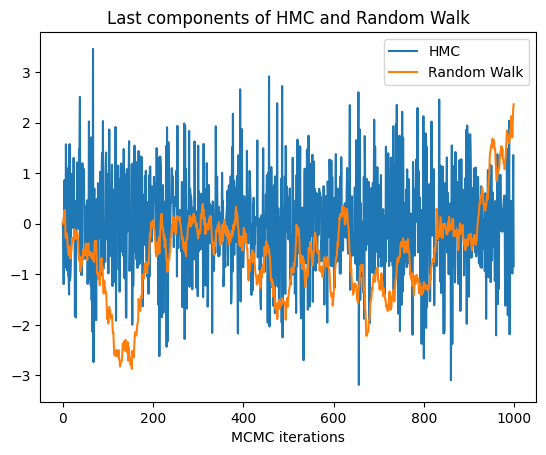

In [12]:
#plot the samples for the last component of the Gaussian distribution as function of 
#MCMC iterations. I.e. extract the last (100th) component from each sample

HMC_samples = HMC_sampling(1000, np.zeros(100), 150, 0.02, potential, potential_grad)
plt.plot(HMC_samples[:, -1], label = "HMC")
plt.plot(np.array(Random_walk_samples[:, -1]), label = "Random Walk")
plt.title("Last components of HMC and Random Walk")
plt.xlabel('MCMC iterations')
plt.legend()
plt.savefig("fig.png", bbox_inches = "tight")
plt.show()

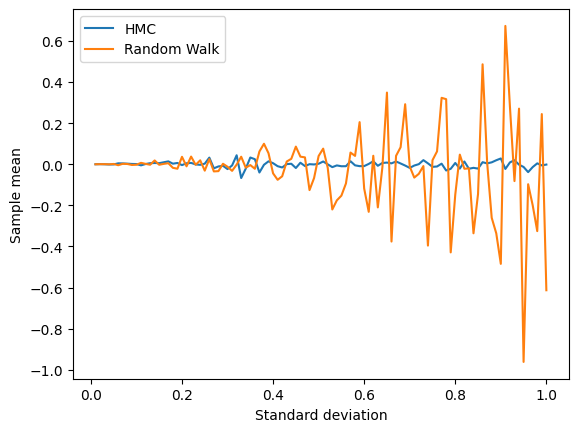

In [14]:
#for each of the algorithms a plot for the sample means for each
# component of the target Gaussian distribution, where the horizontal axis has the
# standard deviations of each component, and the vertical axis correponds to the sample means. 

#calculate sample means for each component
sample_means_HMC = np.zeros(100)
sample_means_RW = np.zeros(100)
for i in range(100):
    sample_means_HMC[i] = np.mean(HMC_samples[:, i])
    sample_means_RW[i] = np.mean(Random_walk_samples[:, i])

#plot them
plt.plot(sigma_vector, sample_means_HMC, label = 'HMC')
plt.plot(sigma_vector, sample_means_RW, label = 'Random Walk')
plt.xlabel('Standard deviation')
plt.ylabel('Sample mean')
plt.legend()
plt.savefig("fig2.png", bbox_inches = "tight")
plt.show()